# TME 5 : AAGB 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import time

## 1. Introduction

In [2]:
all_dict = [{}, {}, {}]
for dico in range(3):
    with open('reseau'+ str(dico+1) + '.txt', 'r') as f:
        for line in f:
            source, point = line.split(',')
            point = int(point.rstrip('\n'))
            all_dict[dico][source] = all_dict[dico].get(source, []) + [int(point)]


## 2. Contexte biologique 

## 3. Degree Distribution 

#### Question 1)

Soit G(V,E) un graph avec V l'ensemble des noeuds
                          E l'ensemble des arêtes
                          
On dit que G est dirigé si les arcs/arêtes ont une direction.
Le degré d'un noeud v (deg(v)) est le nombre de connexions de ce noeuds à d'autres noeuds.

#### Question 2) 

Étudier la distribution des degrés d'un graph est :

-> scale free : distribution suit une loi de puissance 
P(k) = k^-alpha avec (2 < alpha < 3)

-> aléatoire : P(k) = (k parmi n-1) * p^k * q^n-1-k où n est le nombre de noeuds du graphe.

##### Question 3) 

<BarContainer object of 12 artists>

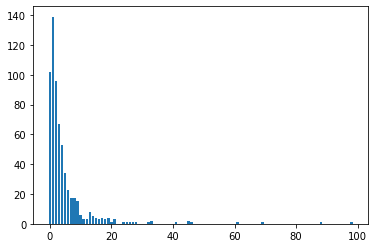

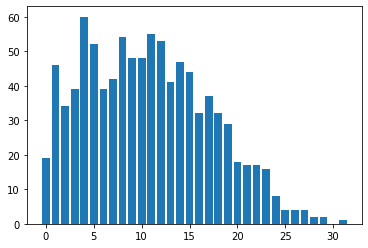

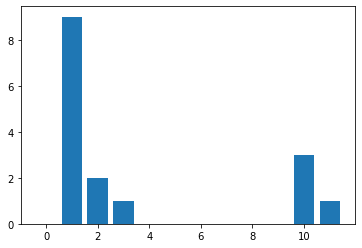

In [3]:
lengths = []
for i in range(2):
    length_i = np.zeros(len(all_dict[i]), dtype= int)
    for j in range(len(length_i)):
        length_i[j] = len(all_dict[i].get(str(j),[]))
    lengths.append(length_i)
    plt.figure()
    plt.bar(np.arange(0,len(np.bincount(length_i))),np.bincount(length_i))


length_i = np.zeros(len(all_dict[2]), dtype=int)
for j,key in enumerate(all_dict[2]):
    length_i[j] = len(all_dict[2].get(key,[]))
lengths.append(length_i)
plt.figure()
plt.bar(np.arange(0,len(np.bincount(length_i))),np.bincount(length_i))

##### Question 4)

Un réseau scale-free est un réseau dont la distribution des degrés des noeuds suit une loi de puissance, c'est le cas dans le premier réseau.
L'autre est aléatoire car il sa distribution de degrés suit une loi binomiale.

## 4. Clustering coefficient 

###### Définition :

On souhaite calculer le coefficient de clustering, pour cela on note :  
    -v le noeud  
    -kv son degré  
    -Nv le nombre de connexions entre ses voisins
    
Ainsi la formule du coefficient de clustering local est :
    
    cc(v) = 2 x Nv/(kv x (kv-1))

###### Question 1)

Pour cc(A),  
kA = 10  
NA = 0  
Donc cc(A) = 2x0/(10x9) = 0  
  
Pour cc(B),  
kB = 10  
NB = 4  
Donc cc(B) = 2x4/(10x9) = 4/45  
  
Pour cc(C),  
kC = 10  
NC = 2  
Donc cc(C) = 2x2/(10x9) = 2/45  
  
Pour cc(D),  
kD = 3  
ND = 1  
Donc cc(D) = 2x1/(3x2) = 1/3  
  
Pour cc(E),  
kE = 10  
NE = 6  
Donc cc(E) = 2x6/(10x9) = 2/15

In [4]:
def mean_CC(dico):
    """
    Fonction calculant la moyenne des coefficients de clustering d'un réseau donné
    """
    S = 0 # initialisation de la somme des coefficients de clustering
    
    # Pour chaque sommet du réseau, on regarde les sommets connectés à celui-ci :
    # Si ceux si sont connectés à d'autres sommets apartenant aux connexions du noeud origine (node)
    # alors on incrémente de 1 le score ENv (ie E(N(v)) le nombre de triangles passant par le noeud v)
    for node in dico.keys():
        degree = len(dico[node])
        ENv = 0
        for i in dico[node]:
            i = str(i)
            if i in dico:
                for key in dico[i]:
                    if key in dico[node]:
                        ENv+=1
            # Si le degré du noeud (ie le nombre de sommets connectés à celui-ci) est inférieur à deux
            # (ie égal à 1 c'est à dire un sommet isolé) alors son coefficient est nul sinon il vaut :
            if degree>2:
                S+= 2*ENv/(degree*(degree-1))
    return S / len(dico)

for k in range(len(all_dict)):
    print('Réseau n°', k+1, mean_CC(all_dict[k]))

Réseau n° 1 0.01336050682215795
Réseau n° 2 0.12117462819917715
Réseau n° 3 0.13876262626262625


On en déduit donc que le réseau 1, qui est scale free est très peu interconnecté tandis que les deux autres réseaux aléatoires sont eux bien plus connectés. Mais de manière générale les voisins d'un noeud sont rarement connectés (12-14% pour les réseaux aléatoires et 1.3% pour le réseau scale-free.

## 5. Betweenness centrality 

###### Question 1) 

Les noeuds qui servent de "hub" permettent de mettre en évidence le concept de betweenness centrality.  
En effet une forte centralité intermédiaire pourrait indiquer que l'on passe souvent pas le noeud "v" qui sert de hub et qui donne accès à de nombreux autres noeuds.  
  
Un réseau contenant quelques noeuds avec une forte centralité est assez robuste car il comporte uniquement quelques hubs qui affectent d'autres noeuds plus isolés.  
Ainsi, ajouter quelques noeuds ne changera rien à l'influence de ces dits hubs.  
  
On pourrait utiliser cette mesure afin de détecter des noeuds "hubs" ou "leaders" autour desquels peuvent s'organiser des groupes. Ces groupes sous influence pourraient donc être décemment considérés comme des communautés.

###### Question 2) 

In [5]:
def betweenness_centrality_s_t(dico, s, t, path):
    # Tant qu'on a pas trouvé un plus court chemin on rajoute une colonne et on continue les chemins 
    # Critère d'arrêt : si un des derniers sommets est la cible t alors on a trouvé au minimum 1 plus petit chemin
    while not (path[:,-1] == t ).any() == True :
        # Sécurité d'arrêt : dans le cas où aucun chemin ne mène de s à t
        if all(path[-1]==-1) == True:
            break
        cop_path = np.zeros(len(path[0])+1)-1 # on suppose que -1 n'est pas une clé et sera le critère de break
        cop_path = np.expand_dims(cop_path, axis=0) # array d'une dimension que l'on doit étendre à 2 pour pouvoir  faire les calculs suivants
        
        # Pour chaque chemin en mémoire on part du dernier sommet pour aller dans toutes les cibles de ce sommet
        for former_path in path:
            last_node = str(int(former_path[-1]))
            if last_node in dico:
                for new_node in dico[ last_node ]:
                    new_path = np.copy(former_path)
                    new_path = np.append(new_path, [new_node])
                    new_path = np.expand_dims(new_path, axis=0)
                    cop_path = np.concatenate((cop_path, new_path), axis=0)
                    del new_path
        path = np.copy(cop_path)
        del cop_path
    # On prend tous les chemins qui mènent à la cible t
    res = []
    for part in path:
        if part[-1] == t:
            res.append(part)
    del path
    return np.array(res)
        

In [5]:
def betweenness_centrality_s_t(dico, s, t, path):
    # Tant qu'on a pas trouvé un plus court chemin on rajoute une colonne et on continue les chemins 
    # Critère d'arrêt : si un des derniers sommets est la cible t alors on a trouvé au minimum 1 plus petit chemin
    while not (path[:,-1] == t ).any() == True :
        # Sécurité d'arrêt : dans le cas où aucun chemin ne mène de s à t
        if all(path[-1]==-1) == True:
            break
        cop_path = np.zeros(len(path[0])+1)-1 # on suppose que -1 n'est pas une clé et sera le critère de break
        cop_path = np.expand_dims(cop_path, axis=0) # array d'une dimension que l'on doit étendre à 2 pour pouvoir  faire les calculs suivants
   
        # Pour chaque chemin en mémoire on part du dernier sommet pour aller dans toutes les cibles de ce sommet
        for former_path in path:
            last_node = str(int(former_path[-1]))
            if last_node in dico:
                for new_node in dico[ last_node ]:
                    new_path = np.copy(former_path)
                    new_path = np.append(new_path, [new_node])
                    new_path = np.expand_dims(new_path, axis=0)
                    cop_path = np.concatenate((cop_path, new_path), axis=0)
                    del new_path
        path = np.copy(cop_path)
        del cop_path
    # On prend tous les chemins qui mènent à la cible t
    return path[ np.where(path[:,-1]==t)[0] ] 
        

In [6]:
#print(all_dict[0])
depart = 0
arrivee= 973
init = np.array([[depart]])
res = betweenness_centrality_s_t(all_dict[0] , depart, arrivee, init)
print(res)
print(len(res))

[[0]]
[0]
0
False
True
[[  0.  17. 973.]
 [  0. 491. 973.]]
2


In [23]:
st = time.time()
tools = it.combinations(range(len(all_dict[0])), 2)
all_nodes = {}
all_path = 0
# On initialise le nombre total de chemins et le nombre total de fois où l'on passe par un sommet qui n'est pas source ni cible
for tool in tools:
    s, t = tool
    init = np.array([[s]])
    chemins = betweenness_centrality_s_t(all_dict[0] , s, t, init)
    # Si un chemin existe, alots path n'est pas vide
    if chemins.size > 0:
        all_path += len(chemins)
    # On prend chacun de ces chemins et l'on incremente de 1 les compteurs de chaque sommet intermédiaire 
    for sole_path in chemins:
        for node_v in sole_path[1:-1]:
            node_v = int(node_v)
            all_nodes[node_v] = all_nodes.get(node_v, 0) + 1
print(all_nodes)
for key in all_nodes:
    all_nodes[key] /= all_path
print('Execution time:', time.time() - st, 'seconds')

C:\Users\HENRI\AppData\Local\Temp/ipykernel_18472/2102346756.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if chemins != []:
C:\Users\HENRI\AppData\Local\Temp/ipykernel_18472/2102346756.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if chemins != []:


{4: 1362, 5: 1059, 7: 512, 3: 541, 15: 535, 13: 696, 8: 321, 12: 270, 16: 507, 26: 420, 18: 41, 25: 112, 32: 147, 6: 348, 29: 192, 34: 597, 10: 484, 41: 416, 9: 381, 50: 356, 49: 136, 65: 182, 56: 1298, 43: 170, 14: 321, 57: 288, 39: 364, 19: 335, 45: 795, 47: 298, 40: 186, 21: 102, 66: 534, 76: 35, 60: 38, 64: 36, 63: 78, 44: 633, 37: 499, 55: 180, 94: 135, 71: 731, 97: 298, 75: 176, 24: 169, 17: 60, 22: 66, 105: 134, 69: 163, 87: 411, 109: 37, 134: 214, 127: 28, 36: 394, 147: 136, 96: 280, 90: 81, 78: 171, 124: 322, 62: 46, 27: 220, 146: 299, 111: 249, 107: 148, 88: 98, 100: 204, 48: 57, 38: 553, 113: 710, 168: 166, 131: 98, 46: 47, 93: 154, 172: 116, 176: 216, 23: 22, 83: 171, 137: 119, 59: 253, 99: 249, 136: 13, 188: 50, 140: 58, 67: 149, 200: 148, 85: 582, 126: 173, 52: 151, 77: 175, 108: 67, 158: 84, 161: 186, 118: 41, 31: 109, 106: 40, 217: 125, 33: 627, 120: 46, 174: 168, 154: 45, 205: 50, 145: 59, 209: 102, 170: 310, 184: 51, 28: 20, 206: 396, 159: 41, 202: 60, 198: 33, 129: 1

{4: 1362, 5: 1059, 7: 512, 3: 541, 15: 535, 13: 696, 8: 321, 12: 270, 16: 507, 26: 420, 18: 41, 25: 112, 32: 147, 6: 348, 29: 192, 34: 597, 10: 484, 41: 416, 9: 381, 50: 356, 49: 136, 65: 182, 56: 1298, 43: 170, 14: 321, 57: 288, 39: 364, 19: 335, 45: 795, 47: 298, 40: 186, 21: 102, 66: 534, 76: 35, 60: 38, 64: 36, 63: 78, 44: 633, 37: 499, 55: 180, 94: 135, 71: 731, 97: 298, 75: 176, 24: 169, 17: 60, 22: 66, 105: 134, 69: 163, 87: 411, 109: 37, 134: 214, 127: 28, 36: 394, 147: 136, 96: 280, 90: 81, 78: 171, 124: 322, 62: 46, 27: 220, 146: 299, 111: 249, 107: 148, 88: 98, 100: 204, 48: 57, 38: 553, 113: 710, 168: 166, 131: 98, 46: 47, 93: 154, 172: 116, 176: 216, 23: 22, 83: 171, 137: 119, 59: 253, 99: 249, 136: 13, 188: 50, 140: 58, 67: 149, 200: 148, 85: 582, 126: 173, 52: 151, 77: 175, 108: 67, 158: 84, 161: 186, 118: 41, 31: 109, 106: 40, 217: 125, 33: 627, 120: 46, 174: 168, 154: 45, 205: 50, 145: 59, 209: 102, 170: 310, 184: 51, 28: 20, 206: 396, 159: 41, 202: 60, 198: 33, 129: 156, 215: 112, 73: 42, 247: 35, 175: 86, 180: 91, 235: 136, 116: 77, 151: 78, 160: 237, 150: 29, 197: 24, 275: 10, 72: 139, 280: 69, 135: 156, 20: 67, 207: 85, 185: 105, 84: 179, 143: 66, 255: 25, 182: 65, 218: 10, 171: 48, 310: 48, 288: 68, 301: 204, 302: 111, 295: 70, 42: 143, 152: 11, 257: 74, 322: 58, 142: 39, 110: 7, 236: 41, 347: 91, 292: 146, 144: 675, 313: 92, 132: 591, 166: 70, 365: 19, 284: 110, 378: 136, 361: 33, 224: 108, 349: 67, 157: 168, 348: 41, 165: 82, 327: 52, 372: 300, 346: 23, 121: 65, 80: 22, 369: 21, 250: 57, 101: 29, 58: 47, 216: 34, 394: 51, 92: 64, 98: 122, 443: 105, 340: 55, 54: 52, 253: 45, 436: 98, 403: 152, 429: 48, 156: 198, 119: 58, 273: 106, 123: 16, 265: 24, 289: 71, 459: 24, 484: 12, 256: 108, 222: 47, 419: 52, 11: 41, 30: 227, 79: 771, 316: 35, 362: 28, 463: 10, 223: 79, 138: 28, 399: 25, 440: 46, 404: 119, 245: 21, 373: 24, 491: 75, 220: 20, 516: 32, 51: 125, 525: 24, 139: 17, 391: 85, 162: 71, 422: 22, 363: 17, 441: 27, 163: 36, 337: 33, 386: 58, 344: 22, 424: 34, 444: 24, 475: 90, 425: 31, 178: 65, 343: 24, 300: 60, 521: 33, 492: 40, 439: 20, 532: 75, 473: 29, 558: 28, 552: 24, 506: 22, 281: 325, 232: 67, 570: 48, 259: 46, 307: 85, 381: 30, 593: 60, 412: 26, 190: 6, 246: 47, 434: 16, 357: 63, 395: 31, 374: 80, 497: 21, 35: 523, 68: 724, 74: 93, 104: 62, 95: 48, 102: 64, 122: 71, 183: 78, 103: 817, 193: 140, 114: 98, 167: 268, 254: 18, 130: 54, 264: 215, 148: 25, 219: 412, 212: 189, 141: 18, 293: 357, 153: 101, 305: 18, 315: 116, 237: 72, 332: 42, 155: 95, 371: 16, 266: 128, 149: 102, 278: 145, 201: 60, 177: 129, 189: 32, 396: 167, 82: 45, 329: 33, 299: 108, 230: 56, 345: 54, 115: 59, 86: 15, 186: 76, 415: 21, 70: 40, 446: 45, 455: 64, 472: 63, 416: 28, 437: 115, 320: 109, 294: 31, 380: 31, 432: 187, 495: 22, 427: 7, 213: 101, 227: 18, 308: 36, 282: 32, 240: 102, 312: 14, 577: 54, 228: 31, 297: 11, 376: 11, 433: 18, 229: 32, 483: 24, 242: 188, 204: 75, 267: 117, 252: 36, 317: 286, 194: 150, 196: 219, 269: 59, 406: 35, 276: 40, 89: 115, 423: 20, 243: 75, 187: 23, 241: 97, 225: 21, 477: 87, 476: 32, 390: 46, 81: 22, 173: 20, 283: 126, 522: 78, 402: 77, 505: 14, 331: 91, 559: 82, 306: 22, 350: 245, 319: 16, 388: 95, 466: 32, 309: 139, 499: 32, 461: 25, 125: 9, 290: 36, 285: 65, 407: 53, 542: 29, 210: 37, 279: 40, 339: 83, 318: 325, 287: 69, 179: 57, 296: 18, 238: 93, 352: 51, 208: 109, 164: 239, 248: 52, 271: 35, 370: 87, 298: 31, 464: 33, 410: 11, 291: 12, 482: 47, 262: 186, 387: 55, 244: 20, 211: 11}

{4: 0.05821259135786639, 5: 0.04526221310424414, 7: 0.021883147412061377, 3: 0.023122622558447666, 15: 0.02286617942471257, 13: 0.02974740351327093, 8: 0.013719707654827542, 12: 0.011539941018079241, 16: 0.021669444800615462, 26: 0.017951019361456596, 18: 0.0017523614138564773, 25: 0.004786938496388426, 32: 0.006282856776509809, 6: 0.014873701756635466, 29: 0.008206180279523016, 34: 0.025516091806641876, 10: 0.020686412787964268, 41: 0.01778005727229987, 9: 0.016284138992178485, 50: 0.015215625934948926, 49: 0.005812711031328803, 65: 0.007778775056631192, 56: 0.05547719793135872, 43: 0.007265888789161004, 14: 0.013719707654827542, 57: 0.012309270419284524, 39: 0.015557550113262384, 19: 0.014318074966876095, 45: 0.03397871521989999, 47: 0.012736675642176348, 40: 0.007949737145787922, 21: 0.004359533273496602, 66: 0.022823438902423387, 76: 0.001495918280121383, 60: 0.0016241398469889303, 64: 0.0015386588024105655, 63: 0.003333760738556225, 44: 0.027054750609052443, 37: 0.021327520622302004, 55: 0.007693294012052827, 94: 0.0057699705090396205, 71: 0.031243321793392315, 97: 0.012736675642176348, 75: 0.007522331922896097, 24: 0.007223148266871821, 17: 0.0025644313373509426, 22: 0.0028208744710860366, 105: 0.005727229986750438, 69: 0.006966705133136727, 87: 0.017566354660853954, 109: 0.0015813993246997478, 134: 0.009146471769885029, 127: 0.0011967346240971065, 36: 0.016839765781937854, 147: 0.005812711031328803, 96: 0.011967346240971065, 90: 0.0034619823054237724, 78: 0.007308629311450186, 124: 0.013762448177116724, 62: 0.001966064025302389, 27: 0.009402914903620122, 146: 0.01277941616446553, 111: 0.01064239005000641, 107: 0.006325597298798991, 88: 0.004188571184339873, 100: 0.008719066546993203, 48: 0.0024362097704833953, 38: 0.02363550882591785, 113: 0.030345770825319484, 168: 0.007094926700004274, 131: 0.004188571184339873, 46: 0.0020088045475915714, 93: 0.006582040432534086, 172: 0.004957900585545155, 176: 0.009231952814463392, 23: 0.0009402914903620122, 83: 0.007308629311450186, 137: 0.0050861221524127025, 59: 0.010813352139163141, 99: 0.01064239005000641, 136: 0.0005556267897593709, 188: 0.0021370261144591186, 140: 0.0024789502927725776, 67: 0.006368337821088174, 200: 0.006325597298798991, 85: 0.024874983972304143, 126: 0.007394110356028551, 52: 0.0064538188656665385, 77: 0.0074795914006069155, 108: 0.002863614993375219, 158: 0.0035902038722913196, 161: 0.007949737145787922, 118: 0.0017523614138564773, 31: 0.004658716929520879, 106: 0.001709620891567295, 217: 0.005342565286147797, 33: 0.02679830747531735, 120: 0.001966064025302389, 174: 0.007180407744582639, 154: 0.0019233235030132068, 205: 0.0021370261144591186, 145: 0.00252169081506176, 209: 0.004359533273496602, 170: 0.013249561909646535, 184: 0.002179766636748301, 28: 0.0008548104457836475, 206: 0.01692524682651622, 159: 0.0017523614138564773, 202: 0.0025644313373509426, 198: 0.0014104372355430183, 129: 0.00666752147711245, 215: 0.004786938496388426, 73: 0.0017951019361456598, 247: 0.001495918280121383, 175: 0.003675684916869684, 180: 0.003889387528315596, 235: 0.005812711031328803, 116: 0.003291020216267043, 151: 0.003333760738556225, 160: 0.010129503782536223, 150: 0.0012394751463862888, 197: 0.001025772534940377, 275: 0.00042740522289182376, 72: 0.0059409325981963496, 280: 0.002949096037953584, 135: 0.00666752147711245, 20: 0.002863614993375219, 207: 0.003632944394580502, 185: 0.004487754840364149, 84: 0.007650553489763645, 143: 0.0028208744710860366, 255: 0.0010685130572295593, 182: 0.0027781339487968544, 218: 0.00042740522289182376, 171: 0.002051545069880754, 310: 0.002051545069880754, 288: 0.0029063555156644016, 301: 0.008719066546993203, 302: 0.0047441979740992435, 295: 0.002991836560242766, 42: 0.0061118946873530795, 152: 0.0004701457451810061, 257: 0.0031627986493994956, 322: 0.0024789502927725776, 142: 0.0016668803692781126, 110: 0.00029918365602427663, 236: 0.0017523614138564773, 347: 0.003889387528315596, 292: 0.006240116254220627, 144: 0.0288498525451981, 313: 0.003932128050604778, 132: 0.02525964867290678, 166: 0.002991836560242766, 365: 0.0008120699234944652, 284: 0.004701457451810061, 378: 0.005812711031328803, 361: 0.0014104372355430183, 224: 0.004615976407231696, 349: 0.002863614993375219, 157: 0.007180407744582639, 348: 0.0017523614138564773, 165: 0.0035047228277129546, 327: 0.0022225071590374836, 372: 0.012822156686754712, 346: 0.0009830320126511945, 121: 0.0027781339487968544, 80: 0.0009402914903620122, 369: 0.0008975509680728299, 250: 0.0024362097704833953, 101: 0.0012394751463862888, 58: 0.0020088045475915714, 216: 0.0014531777578322008, 394: 0.002179766636748301, 92: 0.002735393426507672, 98: 0.00521434371928025, 443: 0.004487754840364149, 340: 0.0023507287259050304, 54: 0.0022225071590374836, 253: 0.0019233235030132068, 436: 0.004188571184339873, 403: 0.006496559387955721, 429: 0.002051545069880754, 156: 0.00846262341325811, 119: 0.0024789502927725776, 273: 0.004530495362653332, 123: 0.000683848356626918, 265: 0.001025772534940377, 289: 0.0030345770825319484, 459: 0.001025772534940377, 484: 0.0005128862674701885, 256: 0.004615976407231696, 222: 0.0020088045475915714, 419: 0.0022225071590374836, 11: 0.0017523614138564773, 30: 0.0097020985596444, 79: 0.03295294268495961, 316: 0.001495918280121383, 362: 0.0011967346240971065, 463: 0.00042740522289182376, 223: 0.0033765012608454074, 138: 0.0011967346240971065, 399: 0.0010685130572295593, 440: 0.001966064025302389, 404: 0.0050861221524127025, 245: 0.0008975509680728299, 373: 0.001025772534940377, 491: 0.003205539171688678, 220: 0.0008548104457836475, 516: 0.001367696713253836, 51: 0.005342565286147797, 525: 0.001025772534940377, 139: 0.0007265888789161004, 391: 0.003632944394580502, 162: 0.0030345770825319484, 422: 0.0009402914903620122, 363: 0.0007265888789161004, 441: 0.001153994101807924, 163: 0.0015386588024105655, 337: 0.0014104372355430183, 386: 0.0024789502927725776, 344: 0.0009402914903620122, 424: 0.0014531777578322008, 444: 0.001025772534940377, 475: 0.0038466470060264137, 425: 0.0013249561909646536, 178: 0.0027781339487968544, 343: 0.001025772534940377, 300: 0.0025644313373509426, 521: 0.0014104372355430183, 492: 0.001709620891567295, 439: 0.0008548104457836475, 532: 0.003205539171688678, 473: 0.0012394751463862888, 558: 0.0011967346240971065, 552: 0.001025772534940377, 506: 0.0009402914903620122, 281: 0.013890669743984271, 232: 0.002863614993375219, 570: 0.002051545069880754, 259: 0.001966064025302389, 307: 0.003632944394580502, 381: 0.0012822156686754713, 593: 0.0025644313373509426, 412: 0.0011112535795187418, 190: 0.00025644313373509426, 246: 0.0020088045475915714, 434: 0.000683848356626918, 357: 0.0026926529042184894, 395: 0.0013249561909646536, 374: 0.00341924178313459, 497: 0.0008975509680728299, 35: 0.022353293157242382, 68: 0.03094413813736804, 74: 0.003974868572893961, 104: 0.002649912381929307, 95: 0.002051545069880754, 102: 0.002735393426507672, 122: 0.0030345770825319484, 183: 0.003333760738556225, 103: 0.034919006710262, 193: 0.005983673120485532, 114: 0.004188571184339873, 167: 0.011454459973500876, 254: 0.0007693294012052828, 130: 0.002307988203615848, 264: 0.00918921229217421, 148: 0.0010685130572295593, 219: 0.017609095183143138, 212: 0.008077958712655469, 141: 0.0007693294012052828, 293: 0.015258366457238107, 153: 0.00431679275120742, 305: 0.0007693294012052828, 315: 0.004957900585545155, 237: 0.003077317604821131, 332: 0.0017951019361456598, 155: 0.004060349617472325, 371: 0.000683848356626918, 266: 0.005470786853015344, 149: 0.004359533273496602, 278: 0.006197375731931444, 201: 0.0025644313373509426, 177: 0.005513527375304526, 189: 0.001367696713253836, 396: 0.0071376672222934565, 82: 0.0019233235030132068, 329: 0.0014104372355430183, 299: 0.004615976407231696, 230: 0.002393469248194213, 345: 0.002307988203615848, 115: 0.00252169081506176, 86: 0.0006411078343377356, 186: 0.0032482796939778606, 415: 0.0008975509680728299, 70: 0.001709620891567295, 446: 0.0019233235030132068, 455: 0.002735393426507672, 472: 0.0026926529042184894, 416: 0.0011967346240971065, 437: 0.004915160063255973, 320: 0.004658716929520879, 294: 0.0013249561909646536, 380: 0.0013249561909646536, 432: 0.007992477668077104, 495: 0.0009402914903620122, 427: 0.00029918365602427663, 213: 0.00431679275120742, 227: 0.0007693294012052828, 308: 0.0015386588024105655, 282: 0.001367696713253836, 240: 0.004359533273496602, 312: 0.0005983673120485533, 577: 0.002307988203615848, 228: 0.0013249561909646536, 297: 0.0004701457451810061, 376: 0.0004701457451810061, 433: 0.0007693294012052828, 229: 0.001367696713253836, 483: 0.001025772534940377, 242: 0.008035218190366285, 204: 0.003205539171688678, 267: 0.005000641107834338, 252: 0.0015386588024105655, 317: 0.012223789374706159, 194: 0.006411078343377356, 196: 0.00936017438133094, 269: 0.00252169081506176, 406: 0.001495918280121383, 276: 0.001709620891567295, 89: 0.004915160063255973, 423: 0.0008548104457836475, 243: 0.003205539171688678, 187: 0.0009830320126511945, 241: 0.00414583066205069, 225: 0.0008975509680728299, 477: 0.0037184254391588664, 476: 0.001367696713253836, 390: 0.001966064025302389, 81: 0.0009402914903620122, 173: 0.0008548104457836475, 283: 0.005385305808436979, 522: 0.003333760738556225, 402: 0.003291020216267043, 505: 0.0005983673120485533, 331: 0.003889387528315596, 559: 0.0035047228277129546, 306: 0.0009402914903620122, 350: 0.010471427960849681, 319: 0.000683848356626918, 388: 0.004060349617472325, 466: 0.001367696713253836, 309: 0.0059409325981963496, 499: 0.001367696713253836, 461: 0.0010685130572295593, 125: 0.0003846647006026414, 290: 0.0015386588024105655, 285: 0.0027781339487968544, 407: 0.002265247681326666, 542: 0.0012394751463862888, 210: 0.0015813993246997478, 279: 0.001709620891567295, 339: 0.003547463350002137, 318: 0.013890669743984271, 287: 0.002949096037953584, 179: 0.0024362097704833953, 296: 0.0007693294012052828, 238: 0.003974868572893961, 352: 0.002179766636748301, 208: 0.004658716929520879, 164: 0.010214984827114587, 248: 0.0022225071590374836, 271: 0.001495918280121383, 370: 0.0037184254391588664, 298: 0.0013249561909646536, 464: 0.0014104372355430183, 410: 0.0004701457451810061, 291: 0.0005128862674701885, 482: 0.0020088045475915714, 262: 0.007949737145787922, 387: 0.0023507287259050304, 244: 0.0008548104457836475, 211: 0.0004701457451810061}

Nombre de connexions : 23397

In [24]:
print(all_nodes)
print(all_path)

{4: 0.05821259135786639, 5: 0.04526221310424414, 7: 0.021883147412061377, 3: 0.023122622558447666, 15: 0.02286617942471257, 13: 0.02974740351327093, 8: 0.013719707654827542, 12: 0.011539941018079241, 16: 0.021669444800615462, 26: 0.017951019361456596, 18: 0.0017523614138564773, 25: 0.004786938496388426, 32: 0.006282856776509809, 6: 0.014873701756635466, 29: 0.008206180279523016, 34: 0.025516091806641876, 10: 0.020686412787964268, 41: 0.01778005727229987, 9: 0.016284138992178485, 50: 0.015215625934948926, 49: 0.005812711031328803, 65: 0.007778775056631192, 56: 0.05547719793135872, 43: 0.007265888789161004, 14: 0.013719707654827542, 57: 0.012309270419284524, 39: 0.015557550113262384, 19: 0.014318074966876095, 45: 0.03397871521989999, 47: 0.012736675642176348, 40: 0.007949737145787922, 21: 0.004359533273496602, 66: 0.022823438902423387, 76: 0.001495918280121383, 60: 0.0016241398469889303, 64: 0.0015386588024105655, 63: 0.003333760738556225, 44: 0.027054750609052443, 37: 0.0213275206223020

In [7]:
st = time.time()
tools = it.combinations(range(len(all_dict[1])), 2)
all_nodes = {}
all_path = 0
for tool in tools:
    s, t = tool
    init = np.array([[s]])
    chemins = betweenness_centrality_s_t(all_dict[1] , s, t, init)
    if chemins != []:
        all_path += 1
    for sole_path in chemins:
        for node_v in sole_path[1:-1]:
            node_v = int(node_v)
            all_nodes[node_v] = all_nodes.get(node_v, 0) + 1
    del chemins
print(all_nodes)
for key in all_nodes:
    all_nodes[key] /= all_path
print('Execution time:', time.time() - st, 'seconds')

KeyboardInterrupt: 

In [7]:
print(all_dict[0])

{'0': [3, 4, 5, 7, 520, 13, 15, 17, 18, 21, 22, 23, 25, 540, 34, 41, 43, 558, 48, 8, 50, 565, 566, 55, 61, 62, 63, 576, 80, 593, 93, 94, 610, 109, 110, 118, 120, 639, 960, 131, 646, 658, 150, 151, 154, 159, 181, 694, 197, 202, 716, 214, 216, 224, 228, 127, 236, 763, 897, 268, 270, 286, 49, 818, 835, 842, 337, 347, 354, 361, 366, 369, 64, 391, 406, 409, 930, 419, 938, 429, 435, 448, 968, 470, 997, 491, 494, 508], '1': [3, 6, 9, 10, 11, 12, 13, 14, 528, 20, 21, 23, 24, 154, 29, 421, 38, 817, 938, 839, 746, 177, 562, 51, 52, 310, 137, 568, 313, 955, 62, 435, 139, 609, 328, 73, 74, 333, 78, 336, 849, 84, 216, 729, 349, 97, 251, 230, 232, 233, 234, 108, 109, 239, 113, 371, 190, 119, 123, 253, 255], '2': [3, 4, 6, 24, 659, 789, 152, 28, 31, 33, 297, 683, 45, 51, 181, 312, 187, 60, 190, 707, 710, 417, 841, 759, 334, 719, 82, 218, 681, 958, 758, 247], '3': [4, 5, 12, 399, 274, 275, 302, 159, 160, 546, 292, 421, 39, 40, 682, 46, 303, 688, 947, 54, 722, 953, 786, 59, 316, 61, 978, 835, 324, 389,